# Sriram et al. (2012) Model Code

# Table of Contents
1. [Imports](#imports)
2. [Parameters and Initial Conditions](#params)
3. [Put Raw Data into Arrays](#rawdata)
    1. [Plot Data Sets](#plotdata)
4. [Model Function--Includes ODE Solver](#modelfunction)
5. [Functions to Determine Delayed ACTH and Cortisol Values](#delays)
6. [Cost Function Definition](#cost)
7. [Run the Optimization](#run)
8. [Save Output to File](#saveoutput)
9. [Compute Means and Std Devations of Parameters and Output as Table](#paramtable)
10. [Plots](#plots)
11. [Figure 3 Reproduction](#fig3)
12. [Figure 4 Reproduction](#fig4)
13. [Load Parameter Sets, Run Model and Save Hormone Concentration Data](#loadparams)
14. [Checking Parameter Sets Generated Externally](#checkexternal)
15. [Load Simulated Concentration Data from Files and Plot](#load-and-plot)
16. [Dependencies](#dependencies)

## Imports <a name="imports"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate
import matplotlib
import pandas as pd
from HPAmodeling import ODEsolver, costFun, dataImport

## Parameters and Initial Conditions <a name="params"></a>

In [2]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [1,28.7,8.6123,2]

In [3]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 10.1
k_i = 1.51
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [4]:
# or we can initialize the parameters that stay the same as the literature values and optimize all parameters and
#     see what happens

V_S3 = 1.58 # reported as 1.58-5
K_m1 = 2
K_P2 = 0.3 # reported as 0.3-1.8
V_S4 = 1.58 # reported as 1.58-5
K_m2 = 2
K_P3 = 0.3 # reported as 0.3-1.8
V_S5 = 1.58 # reported as 1.58-5
K_m3 = 2
K_d1 = 0.173
K_d2 = 0.035
K_d3 = 0.009
n1 = 5
n2 = 4
K_b = 0.01 # no literature value reported
G_tot = 2 # no literature value reported
V_S2 = 0 # reported as 0-1
K1 = 1
K_d5 = 0.01
p_stress = 10

authors_params = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [5]:
# define the bounds for the parameters to be optimized, k_stress and k_i
bounds = [(5,20), (0.5,3)]

In [6]:
# here are the bounds used for all of the parameters, assuming we want to optimize more than just k_stress and k_i
bounds = [(5,20), (0.5,3), (3,4), (1,2), (7,11), (0.5,1.5), (0.08,2), (0.5,1.2), (0.001,0.008), (0.03,0.08), (0.002,0.005), (0.001,0.01), (0.1,0.5), (4,6), (4,6), (0.008,0.05), (2,5), (0.01,0.07), (0.2,0.7), (0.04,0.09)]

In [7]:
# wider bounds for fitting other data sets than original
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9)]

In [8]:
# wider bounds with p_stress included for Nelson data
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9), (1,100)]


In [9]:
# time interval and step definition, based on XPP model from authors
t_start = -0.01
t_end = 2.35
t_step = 0.01

## Put Raw Data Into Arrays <a name="rawdata"></a>

In [10]:
yehudaControlCortisol, yehudaControlCortisol_smooth, yehudaPTSDCortisol, yehudaPTSDCortisol_smooth, yehudaDepressedCortisol, yehudaDepressedCortisol_smooth = dataImport.yehuda()

In [11]:
carrollControlCortisol, carrollControlCortisol_rearr, carrollControlCortisol_smooth, carrollControlCortisol_rearr_smooth, carrollControlACTH, carrollControlACTH_rearr, carrollControlACTH_smooth, carrollControlACTH_rearr_smooth, carrollHCDepressedCortisol, carrollHCDepressedCortisol_rearr, carrollHCDepressedCortisol_smooth, carrollHCDepressedCortisol_rearr_smooth, carrollHCDepressedACTH, carrollHCDepressedACTH_rearr, carrollHCDepressedACTH_smooth, carrollHCDepressedACTH_rearr_smooth, carrollLCDepressedCortisol, carrollLCDepressedCortisol_rearr, carrollLCDepressedCortisol_smooth, carrollLCDepressedCortisol_rearr_smooth, carrollLCDepressedACTH, carrollLCDepressedACTH_rearr, carrollLCDepressedACTH_smooth, carrollLCDepressedACTH_rearr_smooth = dataImport.carroll()

In [12]:
golierPTSDCortisol, golierPTSDCortisol_rearr, golierPTSDCortisol_smooth, golierPTSDCortisol_rearr_smooth, golierPTSDACTH, golierPTSDACTH_rearr, golierPTSDACTH_smooth, golierPTSDACTH_rearr_smooth, golierNonPTSDTraumaExposedCortisol, golierNonPTSDTraumaExposedCortisol_rearr, golierNonPTSDTraumaExposedCortisol_smooth, golierNonPTSDTraumaExposedCortisol_rearr_smooth, golierNonPTSDTraumaExposedACTH, golierNonPTSDTraumaExposedACTH_rearr, golierNonPTSDTraumaExposedACTH_smooth, golierNonPTSDTraumaExposedACTH_rearr_smooth, golierNonPTSDNonExposedCortisol, golierNonPTSDNonExposedCortisol_rearr, golierNonPTSDNonExposedCortisol_smooth, golierNonPTSDNonExposedCortisol_rearr_smooth, golierNonPTSDNonExposedACTH, golierNonPTSDNonExposedACTH_rearr, golierNonPTSDNonExposedACTH_smooth, golierNonPTSDNonExposedACTH_rearr_smooth = dataImport.golier()

In [13]:
bremnerAbusedPTSDCortisol, bremnerAbusedPTSDCortisol_rearr, bremnerAbusedPTSDCortisol_smooth, bremnerAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedPTSDCortisol, bremnerNonAbusedPTSDCortisol_rearr, bremnerNonAbusedPTSDCortisol_smooth, bremnerNonAbusedPTSDCortisol_rearr_smooth, bremnerNonAbusedNonPTSDCortisol, bremnerNonAbusedNonPTSDCortisol_rearr, bremnerNonAbusedNonPTSDCortisol_smooth, bremnerNonAbusedNonPTSDCortisol_rearr_smooth = dataImport.bremner()

In [14]:
nelsonCortisol, nelsonACTH, nelsonAtypicalCortisol, nelsonAtypicalACTH, nelsonMelancholicCortisol, nelsonMelancholicACTH, nelsonNeitherCortisol, nelsonNeitherACTH, nelsonHealthyCortisol, nelsonHealthyACTH, atypical_ids, melancholic_ids, neither_ids, healthy_ids = dataImport.nelson()

### Plot Data Sets <a name="plotdata"></a>

In [15]:
# convert time scales to hours for the raw data, because the model is in terms of hours
for i in range(len(yehudaControlCortisol)):
    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60
    yehudaControlCortisol_smooth[i,0] = yehudaControlCortisol_smooth[i,0]/60
    yehudaPTSDCortisol_smooth[i,0] = yehudaPTSDCortisol_smooth[i,0]/60
    yehudaDepressedCortisol_smooth[i,0] = yehudaDepressedCortisol_smooth[i,0]/60

In [16]:
# make time scale in hours for graphing
j = 0
k = 0
l = 0

timeCarroll = np.zeros(len(carrollControlCortisol[:,0]))
for i in carrollControlCortisol[:,0]:
    timeCarroll[l] = i/60
    l += 1

In [17]:
for i in range(len(carrollControlCortisol_rearr_smooth)):
    carrollControlACTH[i,0] = timeCarroll[i]
    carrollControlACTH_rearr[i,0] = timeCarroll[i]
    carrollControlACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlACTH_smooth[i,0] = timeCarroll[i]
    
    carrollControlCortisol[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedACTH[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedACTH[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedCortisol[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedCortisol[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_smooth[i,0] = timeCarroll[i]

In [18]:
# convert the Nelson data time scale to hours, also
for i in range(len(nelsonCortisol)):
    nelsonCortisol[i,0] = nelsonCortisol[i,0]/60
    nelsonACTH[i,0] = nelsonACTH[i,0]/60

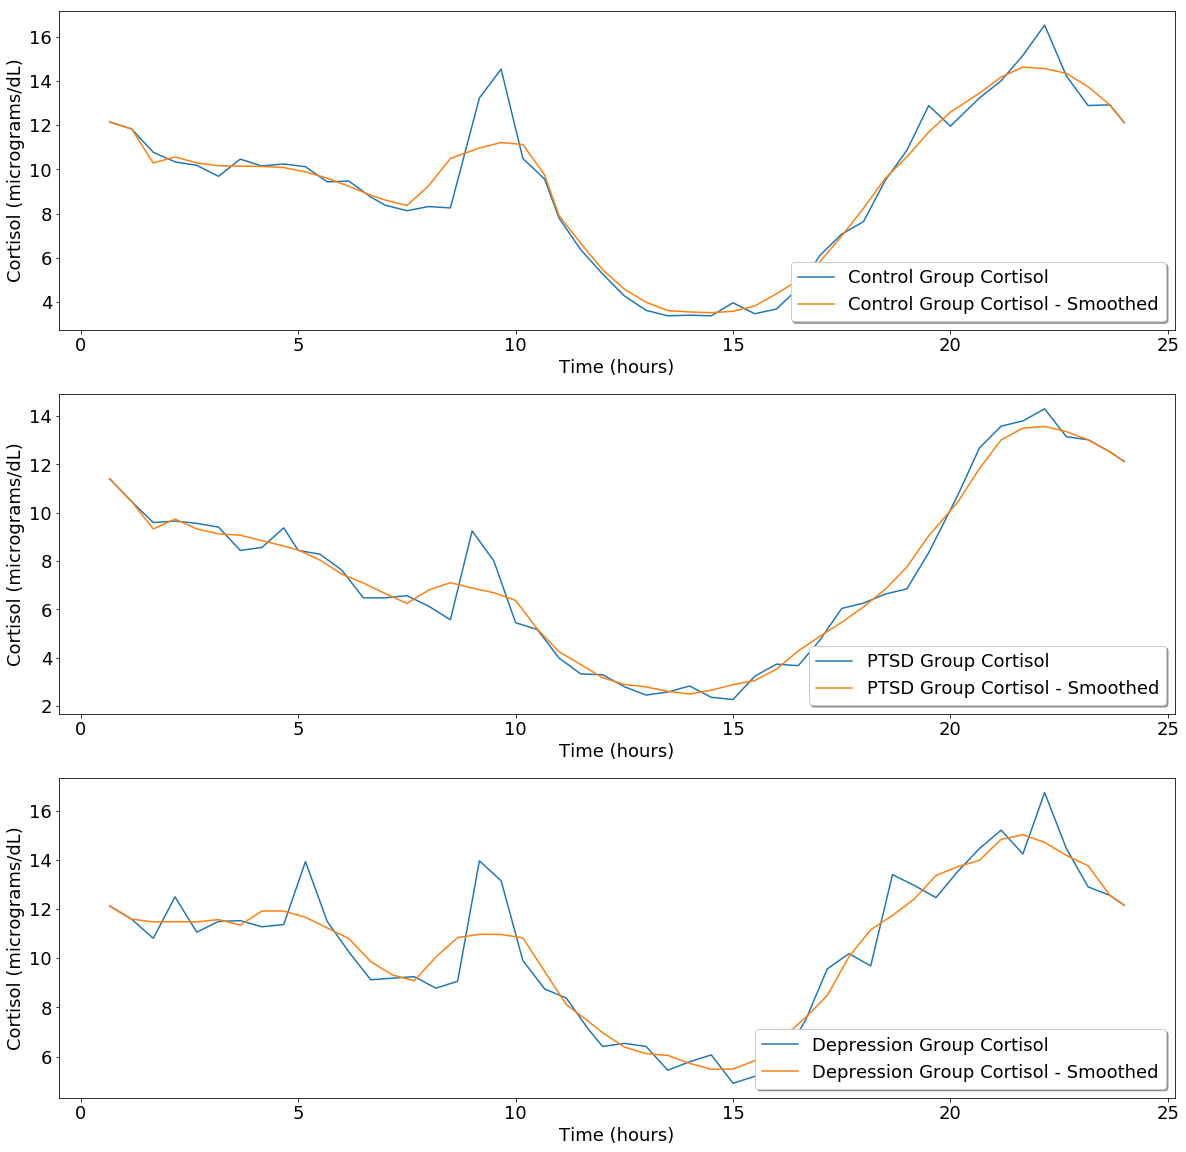

In [19]:
font = {'size'   : 18}
matplotlib.rc('font', **font)

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (20,20))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


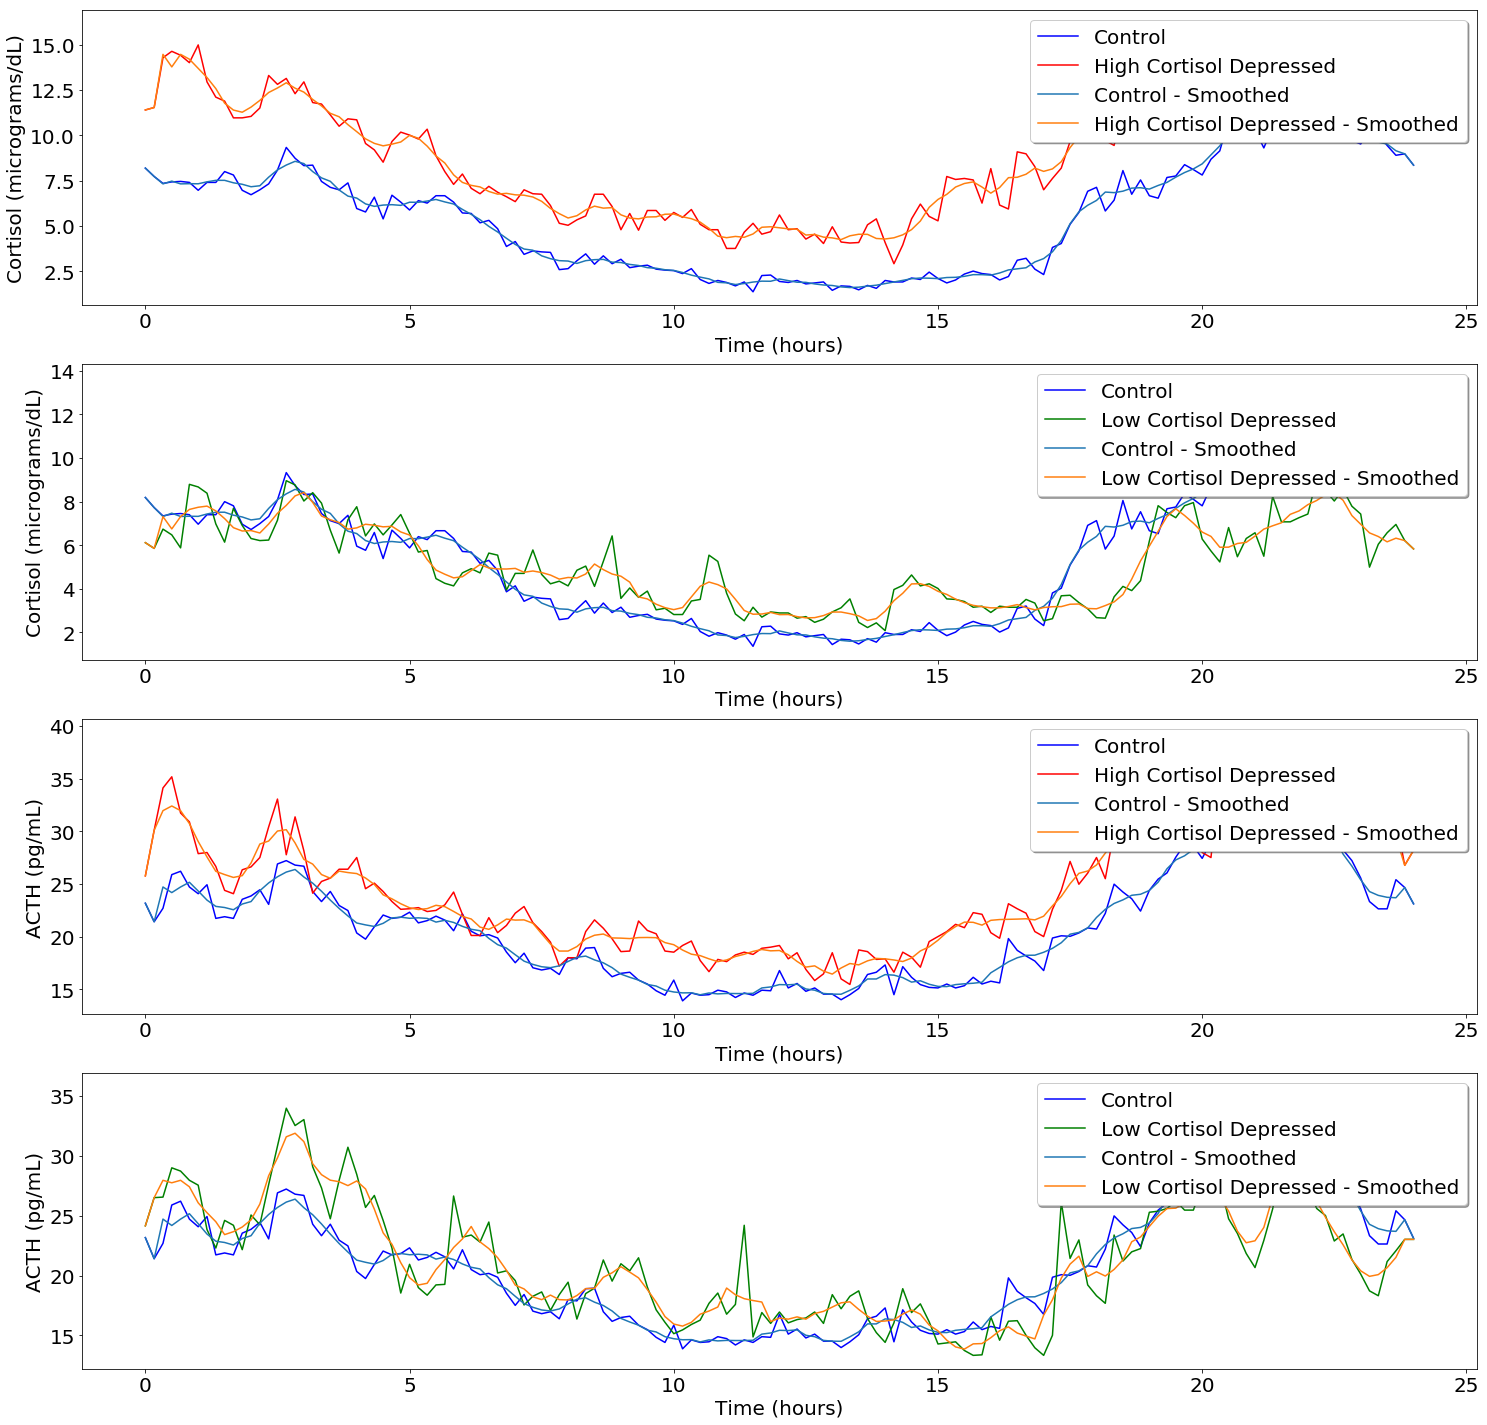

In [20]:
#mpld3.enable_notebook()
%matplotlib inline

font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (25,25))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

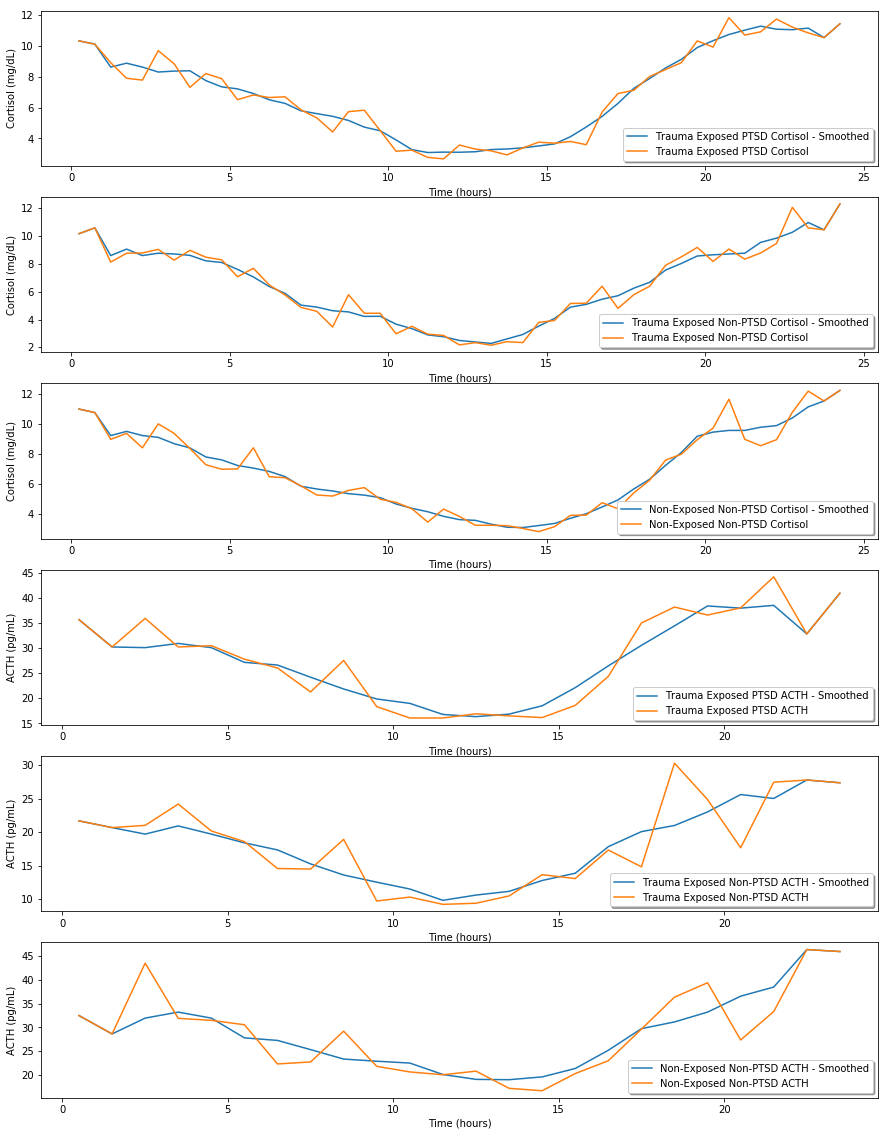

In [21]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


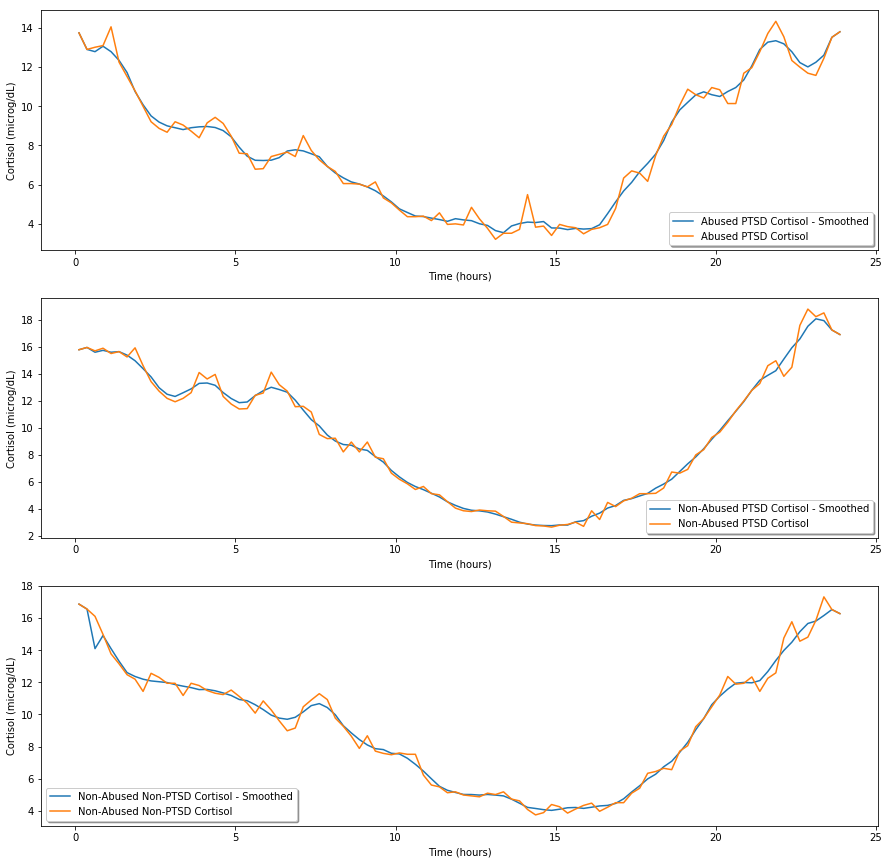

In [22]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


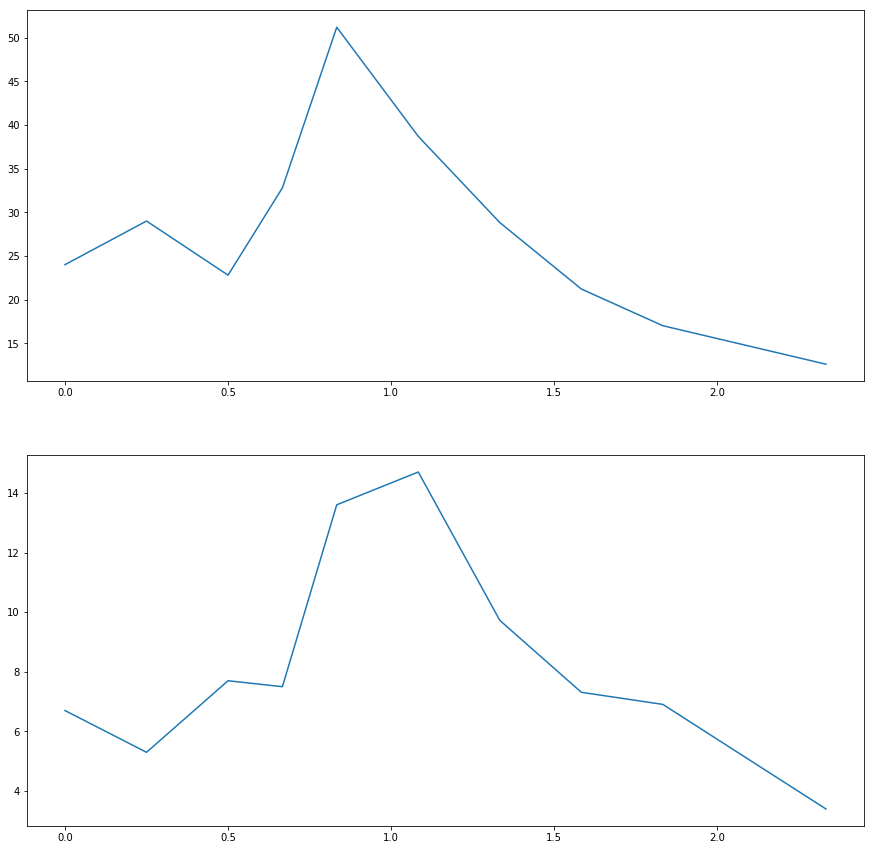

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3])

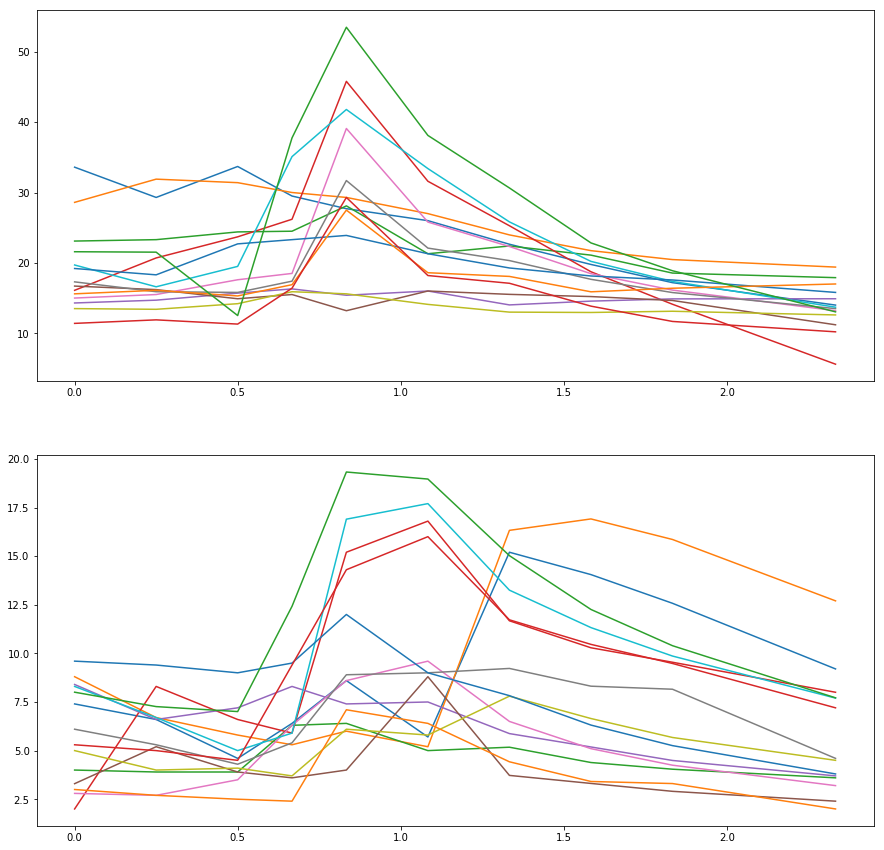

In [24]:
# graph the Nelson data (only showing one patient at a time currently)
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,0])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,2])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,3])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,4])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,5])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,6])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,7])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,8])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,9])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,10])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,11])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,12])
ax1.plot(nelsonACTH[:,0], nelsonAtypicalACTH[:,13])

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,0])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,2])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,4])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,5])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,6])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,7])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,8])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,9])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,10])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,11])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,12])
ax2.plot(nelsonCortisol[:,0], nelsonAtypicalCortisol[:,13])

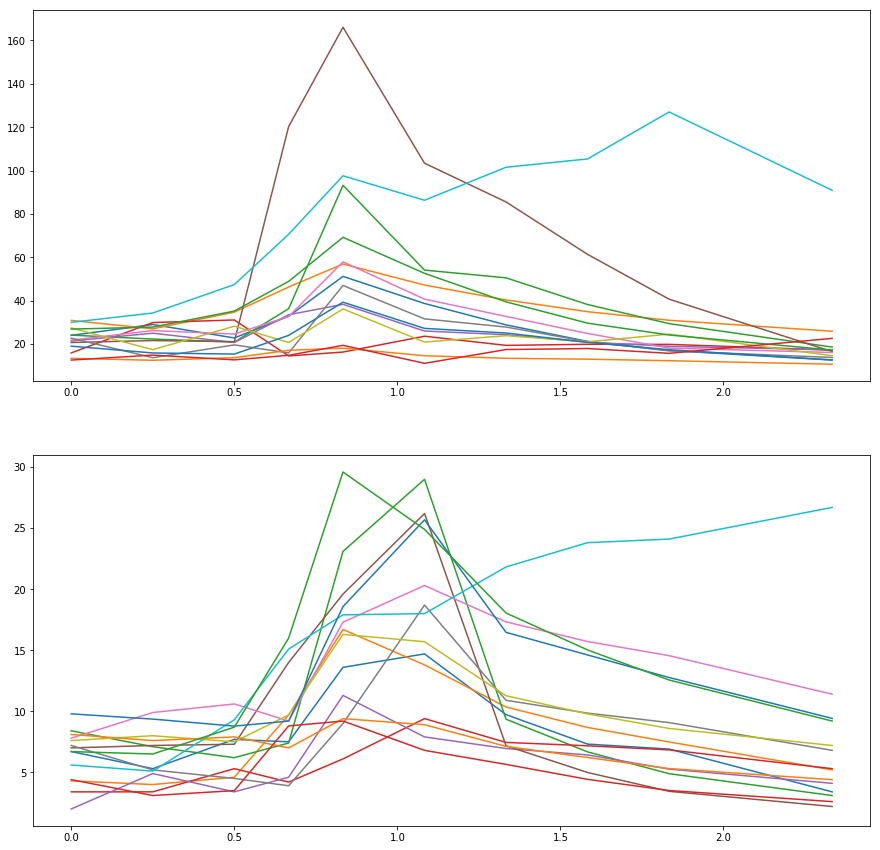

In [25]:
# graph the Nelson data (only showing one patient at a time currently)
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

#ax1.plot(nelsonACTH[:,0], nelsonACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,0])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,1])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,2])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,3])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,4])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,5])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,6])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,7])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,8])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,9])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,10])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,11])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,12])
ax1.plot(nelsonACTH[:,0], nelsonMelancholicACTH[:,13])

#ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,0])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,1])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,2])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,4])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,5])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,6])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,7])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,8])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,9])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,10])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,11])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,12])
ax2.plot(nelsonCortisol[:,0], nelsonMelancholicCortisol[:,13])

## Model Function--Includes ODE Solver <a name="modelfunction"></a>

In [68]:
def model(params, ics):
    def ode_system(t, y):
        dy = np.zeros(4)
        # parameters to be optimized including p_stress
        [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress] = params
        
        # parameters to be optimized not including p_stress
        #[k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5] = params
        
        # Change whether we use the stress_input function to add a time-dependent stressor by changing which equation
        #  for dy[0] is not commented
        dy[0] = stress_input(t)*k_stress*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S3*(y[0]/(K_m1 + y[0])) - K_d1*y[0]
        #dy[0] = k_stress*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S3*(y[0]/(K_m1 + y[0])) - K_d1*y[0]
        dy[1] = K_P2*y[0]*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S4*(y[1]/(K_m2 + y[1])) - K_d2*y[1]
        dy[2] = K_P3*y[1] - V_S5*(y[2]/(K_m3 + y[2])) - K_d3*y[2]
        dy[3] = K_b*y[2]*(G_tot - y[3]) + V_S2*(y[3]**n1/(K1**n1 + y[3]**n1)) - K_d5*y[3]

        return dy
    
    def stress_input(t):
        #if (0.5 <= t <= 0.51):
        if (0.5 <= t <= 0.83):
            return p_stress
        else:
            return 1
    
    timeSeries = ODEsolver.solve(ode_system, ics, t_start, t_step, t_end, ode_steps=1000, ode_atol = 1e-8, ode_rtol = 1e-8)
    return timeSeries

## Cost Function Definition <a name="cost"></a>

In [171]:
def cost_fun(params):
    simData = model(params, y0)
    
    return costFun.cost(params, nelsonACTH[:,0], nelsonNeitherACTH[:,0], nelsonCortisol[:,0], nelsonNeitherCortisol[:,0], simData)


## Run the Optimization <a name="run"></a>

In [172]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [1, nelsonNeitherACTH[0,0], nelsonNeitherCortisol[0,0], 2]
print(y0)

[1, 17.6, 6.0, 2]


In [163]:
# number of times to run the optimization
n = 5

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((237, n))
sims_acth = np.zeros((237, n))
sims_crh = np.zeros((237, n))
sims_gr = np.zeros((237, n))

In [164]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 300, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_gr[:,i] = optimizedSimData[:,4]
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 0.791102
differential_evolution step 2: f(x)= 0.791102
differential_evolution step 3: f(x)= 0.558561
differential_evolution step 4: f(x)= 0.504786
differential_evolution step 5: f(x)= 0.504786
differential_evolution step 6: f(x)= 0.349887
differential_evolution step 7: f(x)= 0.349887
differential_evolution step 8: f(x)= 0.331295
differential_evolution step 9: f(x)= 0.331295
differential_evolution step 10: f(x)= 0.331295
differential_evolution step 11: f(x)= 0.331295
differential_evolution step 12: f(x)= 0.294143
differential_evolution step 13: f(x)= 0.294143
differential_evolution step 14: f(x)= 0.294143
differential_evolution step 15: f(x)= 0.294143
differential_evolution step 16: f(x)= 0.294143
differential_evolution step 17: f(x)= 0.280022
differential_evolution step 18: f(x)= 0.280022
differential_evolution step 19: f(x)= 0.280022
differential_evolution step 20: f(x)= 0.280022
differential_evolution step 21: f(x)= 0.280022
di

differential_evolution step 174: f(x)= 0.217623
differential_evolution step 175: f(x)= 0.217623
differential_evolution step 176: f(x)= 0.217623
differential_evolution step 177: f(x)= 0.217623
differential_evolution step 178: f(x)= 0.217623
differential_evolution step 179: f(x)= 0.217623
differential_evolution step 180: f(x)= 0.217623
differential_evolution step 181: f(x)= 0.217623
differential_evolution step 182: f(x)= 0.217623
differential_evolution step 183: f(x)= 0.217623
differential_evolution step 184: f(x)= 0.217623
differential_evolution step 185: f(x)= 0.217623
differential_evolution step 186: f(x)= 0.217623
differential_evolution step 187: f(x)= 0.217623
differential_evolution step 188: f(x)= 0.217623
differential_evolution step 189: f(x)= 0.217623
differential_evolution step 190: f(x)= 0.217623
differential_evolution step 191: f(x)= 0.217623
differential_evolution step 192: f(x)= 0.217623
differential_evolution step 193: f(x)= 0.217623
differential_evolution step 194: f(x)= 0

differential_evolution step 47: f(x)= 0.273106
differential_evolution step 48: f(x)= 0.272343
differential_evolution step 49: f(x)= 0.272343
differential_evolution step 50: f(x)= 0.272343
differential_evolution step 51: f(x)= 0.272343
differential_evolution step 52: f(x)= 0.272343
differential_evolution step 53: f(x)= 0.272343
differential_evolution step 54: f(x)= 0.265821
differential_evolution step 55: f(x)= 0.265821
differential_evolution step 56: f(x)= 0.261429
differential_evolution step 57: f(x)= 0.261429
differential_evolution step 58: f(x)= 0.261429
differential_evolution step 59: f(x)= 0.261429
differential_evolution step 60: f(x)= 0.261429
differential_evolution step 61: f(x)= 0.261429
differential_evolution step 62: f(x)= 0.261429
differential_evolution step 63: f(x)= 0.261429
differential_evolution step 64: f(x)= 0.261429
differential_evolution step 65: f(x)= 0.261429
differential_evolution step 66: f(x)= 0.261429
differential_evolution step 67: f(x)= 0.261429
differential_

differential_evolution step 221: f(x)= 0.190227
differential_evolution step 222: f(x)= 0.190227
differential_evolution step 223: f(x)= 0.190227
differential_evolution step 224: f(x)= 0.190227
differential_evolution step 225: f(x)= 0.190227
differential_evolution step 226: f(x)= 0.190227
differential_evolution step 227: f(x)= 0.190227
differential_evolution step 228: f(x)= 0.190227
differential_evolution step 229: f(x)= 0.190227
differential_evolution step 230: f(x)= 0.190227
differential_evolution step 231: f(x)= 0.190227
differential_evolution step 232: f(x)= 0.190227
differential_evolution step 233: f(x)= 0.190227
differential_evolution step 234: f(x)= 0.190227
differential_evolution step 235: f(x)= 0.190227
differential_evolution step 236: f(x)= 0.190227
differential_evolution step 237: f(x)= 0.190227
differential_evolution step 238: f(x)= 0.190227
differential_evolution step 239: f(x)= 0.190227
differential_evolution step 240: f(x)= 0.190227
differential_evolution step 241: f(x)= 0

differential_evolution step 95: f(x)= 0.183748
differential_evolution step 96: f(x)= 0.183748
differential_evolution step 97: f(x)= 0.183748
differential_evolution step 98: f(x)= 0.183748
differential_evolution step 99: f(x)= 0.183748
differential_evolution step 100: f(x)= 0.183748
differential_evolution step 101: f(x)= 0.183748
differential_evolution step 102: f(x)= 0.183748
differential_evolution step 103: f(x)= 0.180394
differential_evolution step 104: f(x)= 0.180394
differential_evolution step 105: f(x)= 0.180394
differential_evolution step 106: f(x)= 0.180394
differential_evolution step 107: f(x)= 0.180394
differential_evolution step 108: f(x)= 0.180394
differential_evolution step 109: f(x)= 0.180394
differential_evolution step 110: f(x)= 0.180394
differential_evolution step 111: f(x)= 0.180394
differential_evolution step 112: f(x)= 0.180394
differential_evolution step 113: f(x)= 0.180394
differential_evolution step 114: f(x)= 0.180394
differential_evolution step 115: f(x)= 0.1803

differential_evolution step 83: f(x)= 0.212035
differential_evolution step 84: f(x)= 0.212035
differential_evolution step 85: f(x)= 0.212035
differential_evolution step 86: f(x)= 0.212035
differential_evolution step 87: f(x)= 0.212035
differential_evolution step 88: f(x)= 0.212035
differential_evolution step 89: f(x)= 0.212035
differential_evolution step 90: f(x)= 0.212035
differential_evolution step 91: f(x)= 0.212035
differential_evolution step 92: f(x)= 0.212035
differential_evolution step 93: f(x)= 0.212035
differential_evolution step 94: f(x)= 0.212035
differential_evolution step 95: f(x)= 0.212035
differential_evolution step 96: f(x)= 0.212035
differential_evolution step 97: f(x)= 0.212035
differential_evolution step 98: f(x)= 0.212035
differential_evolution step 99: f(x)= 0.212035
differential_evolution step 100: f(x)= 0.212035
differential_evolution step 101: f(x)= 0.210638
differential_evolution step 102: f(x)= 0.210638
differential_evolution step 103: f(x)= 0.210638
different

differential_evolution step 72: f(x)= 0.256592
differential_evolution step 73: f(x)= 0.244073
differential_evolution step 74: f(x)= 0.244073
differential_evolution step 75: f(x)= 0.244073
differential_evolution step 76: f(x)= 0.244073
differential_evolution step 77: f(x)= 0.244073
differential_evolution step 78: f(x)= 0.244073
differential_evolution step 79: f(x)= 0.244073
differential_evolution step 80: f(x)= 0.244073
differential_evolution step 81: f(x)= 0.244073
differential_evolution step 82: f(x)= 0.244073
differential_evolution step 83: f(x)= 0.244073
differential_evolution step 84: f(x)= 0.244073
differential_evolution step 85: f(x)= 0.244073
differential_evolution step 86: f(x)= 0.244073
differential_evolution step 87: f(x)= 0.242642
differential_evolution step 88: f(x)= 0.242642
differential_evolution step 89: f(x)= 0.242642
differential_evolution step 90: f(x)= 0.242642
differential_evolution step 91: f(x)= 0.242642
differential_evolution step 92: f(x)= 0.242642
differential_

differential_evolution step 246: f(x)= 0.182095
differential_evolution step 247: f(x)= 0.182095
differential_evolution step 248: f(x)= 0.182095
differential_evolution step 249: f(x)= 0.182095
differential_evolution step 250: f(x)= 0.182095
differential_evolution step 251: f(x)= 0.182095
differential_evolution step 252: f(x)= 0.182095
differential_evolution step 253: f(x)= 0.182095
differential_evolution step 254: f(x)= 0.182095
differential_evolution step 255: f(x)= 0.182095
differential_evolution step 256: f(x)= 0.182095
differential_evolution step 257: f(x)= 0.182095
differential_evolution step 258: f(x)= 0.182095
differential_evolution step 259: f(x)= 0.181556
differential_evolution step 260: f(x)= 0.181556
differential_evolution step 261: f(x)= 0.181556
differential_evolution step 262: f(x)= 0.181556
differential_evolution step 263: f(x)= 0.181556
differential_evolution step 264: f(x)= 0.181556
differential_evolution step 265: f(x)= 0.181556
differential_evolution step 266: f(x)= 0

## Save Output to File <a name="saveoutput"></a>

In [165]:
df_t = pd.DataFrame(optimizedSimData[:,0])
df_gr = pd.DataFrame(sims_gr)
df_cort = pd.DataFrame(sims_cort)
df_acth = pd.DataFrame(sims_acth)
df_crh = pd.DataFrame(sims_crh)

df_t.to_excel(excel_writer = 'sriramModel-nelson-neither-patientID_4-timeSteps-5-iterations-p_stress.xlsx')
df_gr.to_excel(excel_writer = 'sriramModel-nelson-neither-patientID_4-sims-gr-5-iterations-p_stress.xlsx')
df_cort.to_excel(excel_writer = 'sriramModel-nelson-neither-patientID_4-sims-cort-5-iterations-p_stress.xlsx')
df_acth.to_excel(excel_writer = 'sriramModel-nelson-neither-patientID_4-sims-acth-5-iterations-p_stress.xlsx')
df_crh.to_excel(excel_writer = 'sriramModel-nelson-neither-patientID_4-sims-crh-5-iterations-p_stress.xlsx')

In [166]:
np.savetxt('sriramModel-nelson-neither-patientID_4-opt-pars-5-iterations-p_stress.txt', opt_pars)
np.savetxt('sriramModel-nelson-neither-patientID_4-timeSteps-5-iterations-p_stress.txt', optimizedSimData[:,0])
np.savetxt('sriramModel-nelson-neither-patientID_4-sims-gr-5-iterations-p_stress.txt', sims_gr)
np.savetxt('sriramModel-nelson-neither-patientID_4-sims-crh-5-iterations-p_stress.txt', sims_crh)
np.savetxt('sriramModel-nelson-neither-patientID_4-sims-acth-5-iterations-p_stress.txt', sims_acth)
np.savetxt('sriramModel-nelson-neither-patientID_4-sims-cort-5-iterations-p_stress.txt', sims_cort)
np.savetxt('sriramModel-nelson-neither-patientID_4-initial-conditions-5-iterations-p_stress.txt', y0)
np.savetxt('sriramModel-nelson-neither-patientID_4-bounds-5-iterations-p_stress.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table <a name="paramtable"></a>

In [167]:
k_stress_mean = np.mean(opt_pars[:,1])
k_stress_std = np.std(opt_pars[:,1])
k_i_mean = np.mean(opt_pars[:,2])
k_i_std = np.std(opt_pars[:,2])
V_S3_mean = np.mean(opt_pars[:,3])
V_S3_std = np.std(opt_pars[:,3])
K_m1_mean = np.mean(opt_pars[:,4])
K_m1_std = np.std(opt_pars[:,4])
K_P2_mean = np.mean(opt_pars[:,5])
K_P2_std = np.std(opt_pars[:,5])
V_S4_mean = np.mean(opt_pars[:,6])
V_S4_std = np.std(opt_pars[:,6])
K_m2_mean = np.mean(opt_pars[:,7])
K_m2_std = np.std(opt_pars[:,7])
K_P3_mean = np.mean(opt_pars[:,8])
K_P3_std = np.std(opt_pars[:,8])
V_S5_mean = np.mean(opt_pars[:,9])
V_S5_std = np.std(opt_pars[:,9])
K_m3_mean = np.mean(opt_pars[:,10])
K_m3_std = np.std(opt_pars[:,10])
K_d1_mean = np.mean(opt_pars[:,11])
K_d1_std = np.std(opt_pars[:,11])
K_d2_mean = np.mean(opt_pars[:,12])
K_d2_std = np.std(opt_pars[:,12])
K_d3_mean = np.mean(opt_pars[:,13])
K_d3_std = np.std(opt_pars[:,13])
n1_mean = np.mean(opt_pars[:,14])
n1_std = np.std(opt_pars[:,14])
n2_mean = np.mean(opt_pars[:,15])
n2_std = np.std(opt_pars[:,15])
K_b_mean = np.mean(opt_pars[:,16])
K_b_std = np.std(opt_pars[:,16])
G_tot_mean = np.mean(opt_pars[:,17])
G_tot_std = np.std(opt_pars[:,17])
V_S2_mean = np.mean(opt_pars[:,18])
V_S2_std = np.std(opt_pars[:,18])
K1_mean = np.mean(opt_pars[:,19])
K1_std = np.std(opt_pars[:,19])
K_d5_mean = np.mean(opt_pars[:,20])
K_d5_std = np.std(opt_pars[:,20])
p_stress_mean = np.mean(opt_pars[:,21])
p_stress_std = np.std(opt_pars[:,21])

In [168]:
print(tabulate([["k_stress", "%f +- %f" % (k_stress_mean, k_stress_std)], ["k_i", "%f +- %f" % (k_i_mean, k_i_std)], ["V_S3", "%f +- %f" % (V_S3_mean, V_S3_std)], ["K_m1", "%f +- %f" % (K_m1_mean, K_m1_std)], ["K_P2", "%f +- %f" % (K_P2_mean, K_P2_std)], ["V_S4", "%f +- %f" % (V_S4_mean, V_S4_std)], ["K_m2", "%f +- %f" % (K_m2_mean, K_m2_std)], ["K_P3", "%f +- %f" % (K_P3_mean, K_P3_std)], ["V_S5", "%f +- %f" % (V_S5_mean, V_S5_std)], ["K_m3", "%f +- %f" % (K_m3_mean, K_m3_std)], ["K_d1", "%f +- %f" % (K_d1_mean, K_d1_std)], ["K_d2", "%f +- %f" % (K_d2_mean, K_d2_std)], ["K_d3", "%f +- %f" % (K_d3_mean, K_d3_std)], ["n1", "%f +- %f" % (n1_mean, n1_std)], ["n2", "%f +- %f" % (n2_mean, n2_std)], ["K_b", "%f +- %f" % (K_b_mean, K_b_std)], ["G_tot", "%f +- %f" % (G_tot_mean, G_tot_std)], ["V_S2", "%f +- %f" % (V_S2_mean, V_S2_std)], ["K1", "%f +- %f" % (K1_mean, K1_std)], ["K_d5", "%f +- %f" % (K_d5_mean, K_d5_std)], ["p_stress", "%f +- %f" % (p_stress_mean, p_stress_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


Parameter    Mean +- Standard Deviation
-----------  ----------------------------
k_stress     8.600311 +- 2.282089
k_i          3.370560 +- 1.076931
V_S3         7.329676 +- 1.534684
K_m1         3.489154 +- 2.634670
K_P2         10.352607 +- 8.359760
V_S4         7.673552 +- 1.474989
K_m2         0.865490 +- 0.792641
K_P3         1.108484 +- 0.199082
V_S5         0.054529 +- 0.017166
K_m3         0.265142 +- 0.099012
K_d1         0.039168 +- 0.015548
K_d2         0.086425 +- 0.014663
K_d3         4.100745 +- 0.821648
n1           7.922818 +- 3.213121
n2           7.954067 +- 4.948874
K_b          0.036105 +- 0.014046
G_tot        17.427003 +- 8.445428
V_S2         3.841225 +- 1.417211
K1           3.663088 +- 1.186909
K_d5         0.473497 +- 0.314549
p_stress     44.548226 +- 10.716279


In [169]:
np.savetxt('sriramModel-nelson-neither-patientID_4-param-means-stds-5-iterations-p_stress.txt', [k_stress_mean, k_stress_std, k_i_mean, k_i_std, V_S3_mean, V_S3_std, K_m1_mean, K_m1_std, K_P2_mean, K_P2_std, V_S4_mean, V_S4_std, K_m2_mean, K_m2_std, K_P3_mean, K_P3_std, V_S5_mean, V_S5_std, K_m3_mean, K_m3_std, K_d1_mean, K_d1_std, K_d2_mean, K_d2_std, K_d3_mean, K_d3_std, n1_mean, n1_std, n2_mean, n2_std, K_b_mean, K_b_std, G_tot_mean, G_tot_std, V_S2_mean, V_S2_std, K1_mean, K1_std, K_d5_mean, K_d5_std])


## Plots <a name="plots"></a>

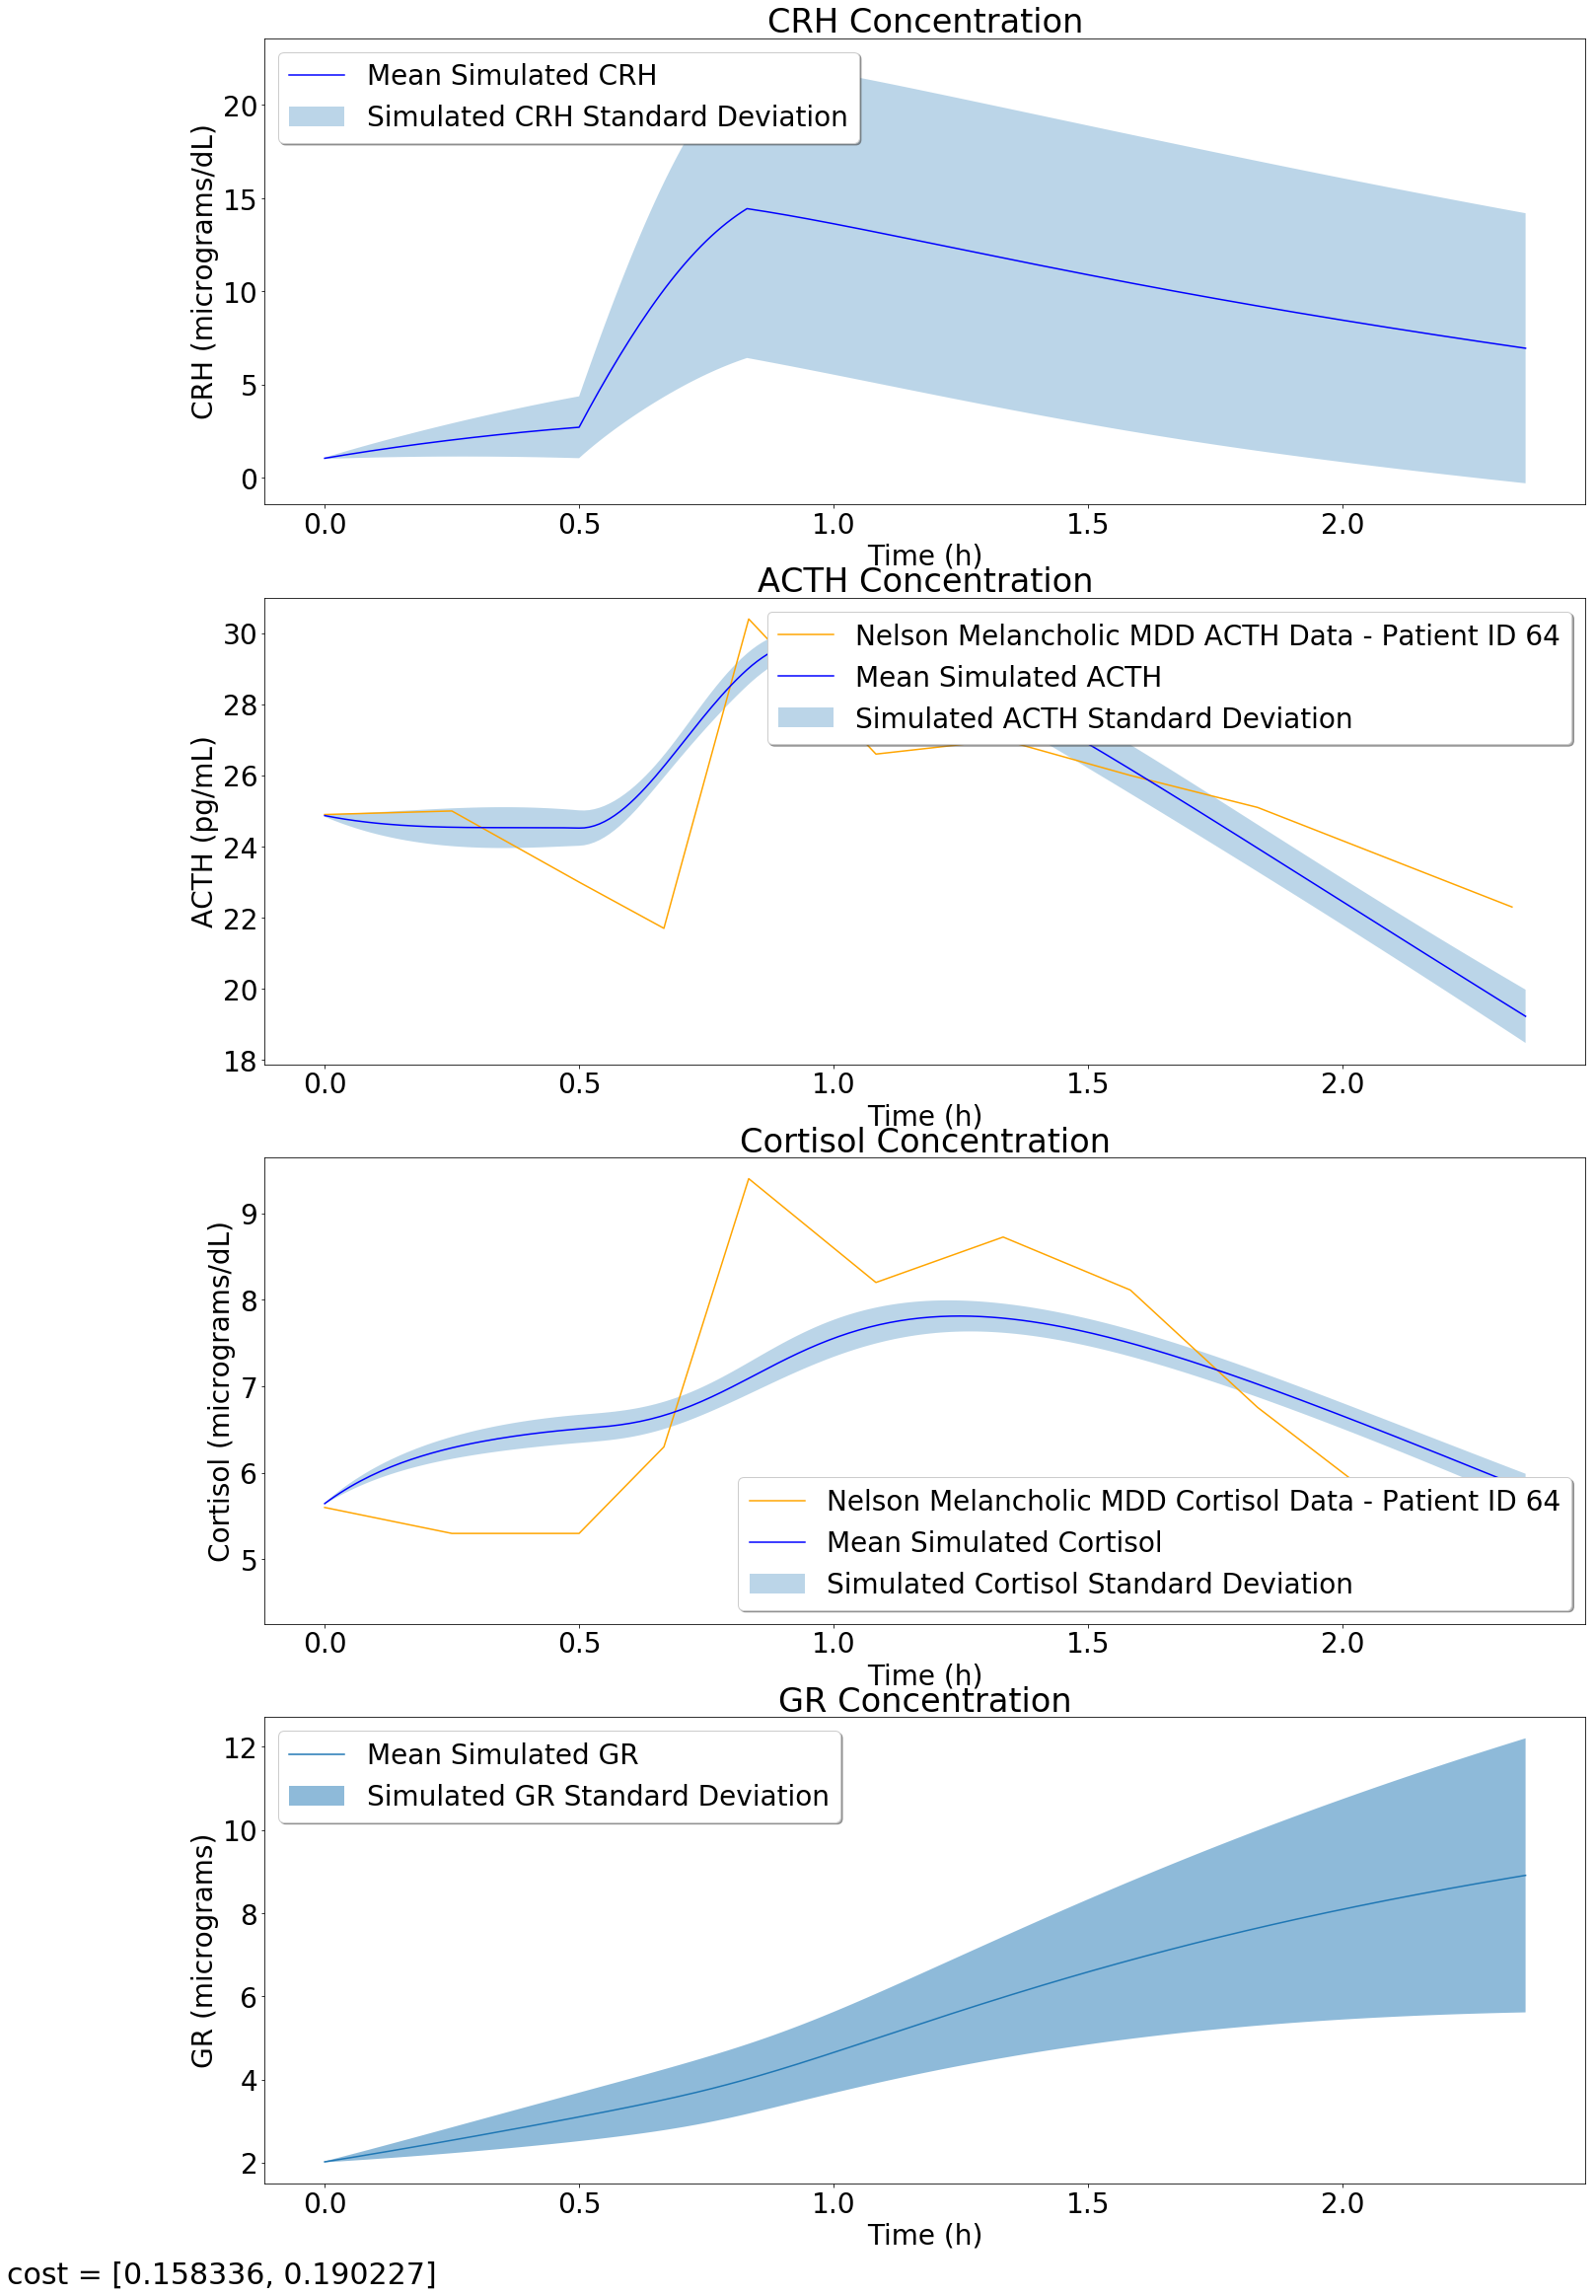

In [170]:
%matplotlib inline
# plot of raw data with simulation data for cortisol, then just simulation data for crh and acth

matplotlib.rc('font', **{'size'   : 28})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(24,40))

#ax1.plot(optimizedSimData[:,0], sims_crh, label = "Mean Simulated CRH")
# for more than 1 iteration, uncomment below
ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Mean Simulated CRH", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "CRH Concentration")

#ax2.plot(optimizedSimData[:,0], sims_acth, label = "Mean")
ax2.plot(nelsonACTH[:,0], nelsonNeitherACTH[:,0], label = "Nelson Neither MDD ACTH Data - Patient ID 4", color = "orange")
# for more than 1 iteration, uncomment below
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Mean Simulated ACTH", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper right", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "ACTH Concentration")

#ax3.plot(optimizedSimData[:,0], sims_cort, label = "Simulation Mean")
ax3.plot(nelsonCortisol[:,0], nelsonNeitherCortisol[:,0], label = "Nelson Neither MDD Cortisol Data - Patient ID 4", color = "orange")
# for more than 1 iteration, uncomment below
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Mean Simulated Cortisol", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "lower right", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Cortisol Concentration")

#ax4.plot(optimizedSimData[:,0], sims_gr, label = "Mean")
# for more than 1 iteration, uncomment below
ax4.plot(optimizedSimData[:,0], np.mean(sims_gr, axis = 1), label = "Mean Simulated GR")
ax4.fill_between(optimizedSimData[:,0], np.mean(sims_gr, axis = 1) - np.std(sims_gr, axis = 1), np.mean(sims_gr, axis = 1) + np.std(sims_gr, axis = 1), alpha = 0.5, label = "Simulated GR Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "GR (micrograms)", title = "GR Concentration")

txt = "cost = []"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 30)
#plt.savefig("sriramModel-nelson-atypical-patientID_1-5-iterations-all-params-normalizedCost.png", dpi = 300)
# include p_stress in filename to indicate that we used stress_input function
plt.savefig("sriramModel-nelson-neither-patientID_4-5-iterations-all-params-normalizedCost-p_stress.png", dpi = 300)


## Figure 3 Reproduction <a name="fig3"></a>

In [66]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 10.1
k_i = 1.51
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_control = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [67]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 13.7
k_i = 1.6
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_depressed = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [68]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

k_stress = 17.5
k_i = 1.17
V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854
p_stress = 1

authors_params_ptsd = [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress]

In [69]:
y0_control = [1, 5, 5, 2]
y0_depressed = [1, 5, 5, 2]
y0_ptsd = [1, 5, 5, 2]

t_start = -0.01
t_end = 300.01
t_step = 0.01

In [72]:
%%time

no_opt_control = model(authors_params_control, y0_control)
no_opt_depressed = model(authors_params_depressed, y0_depressed)
no_opt_ptsd = model(authors_params_ptsd, y0_ptsd)

sims_gr_control = no_opt_control[:,4]
sims_cort_control = no_opt_control[:,3]
sims_acth_control = no_opt_control[:,2]
sims_crh_control = no_opt_control[:,1]

sims_gr_depressed = no_opt_depressed[:,4]
sims_cort_depressed = no_opt_depressed[:,3]
sims_acth_depressed = no_opt_depressed[:,2]
sims_crh_depressed = no_opt_depressed[:,1]

sims_gr_ptsd = no_opt_ptsd[:,4]
sims_cort_ptsd = no_opt_ptsd[:,3]
sims_acth_ptsd = no_opt_ptsd[:,2]
sims_crh_ptsd = no_opt_ptsd[:,1]

CPU times: user 844 ms, sys: 25.8 ms, total: 870 ms
Wall time: 868 ms


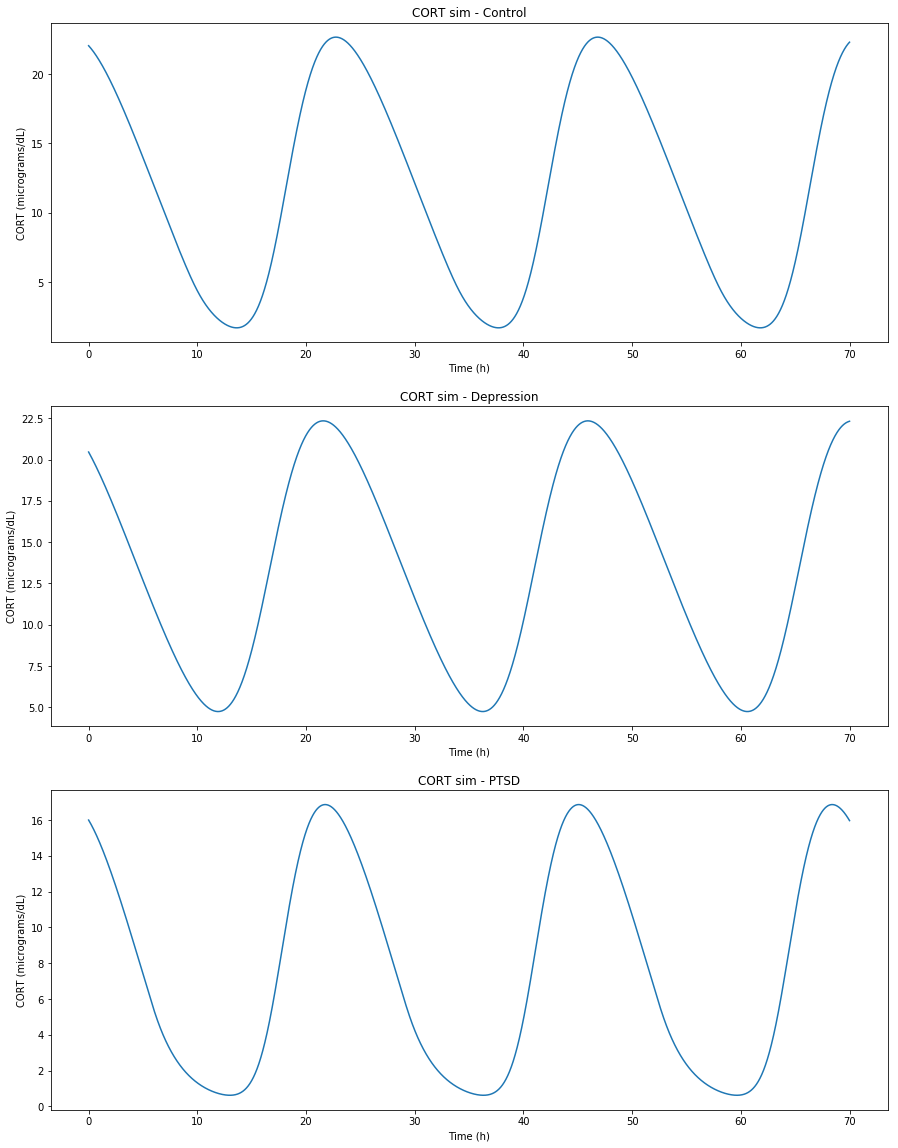

In [73]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,20))

ax1.plot(np.arange(0, 70, 0.01), sims_cort_control[-7800:-800], label = "CORT sim - Control")
ax1.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - Control")
#ax1.legend(loc = "upper right", shadow = True, fancybox = True)

ax2.plot(np.arange(0, 70, 0.01), sims_cort_depressed[-8800:-1800], label = "CORT sim - Depression")
ax2.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - Depression")
#ax2.legend(loc = "upper right", shadow = True, fancybox = True)

ax3.plot(np.arange(0, 70, 0.01), sims_cort_ptsd[-9100:-2100], label = "CORT sim - PTSD")
ax3.set(ylabel = "CORT (micrograms/dL)", xlabel = "Time (h)", title = "CORT sim - PTSD")
#ax3.legend(loc = "upper right", shadow = True, fancybox = True)

plt.savefig("sriramModel-figure3-reproduction.png", dpi=300)

## Figure 4 Reproduction <a name="fig4"></a>

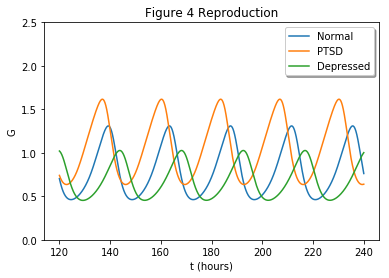

In [74]:
# create Fig 4 of free glucocorticoid receptor level
t_end = 240.01

normal = model(authors_params_control, y0)
PTSD = model(authors_params_ptsd, y0)
depressed = model(authors_params_depressed, y0)

G_normal = G_tot - normal[:,4]
G_PTSD = G_tot - PTSD[:,4]
G_depressed = G_tot - depressed[:,4]

plt.plot(normal[-12000:,0], G_normal[-12000:], label='Normal')
plt.plot(PTSD[-12000:,0], G_PTSD[-12000:], label='PTSD')
plt.plot(depressed[-12000:,0], G_depressed[-12000:], label='Depressed')
plt.ylim(0,2.5)
plt.xlabel('t (hours)')
plt.ylabel('G')
plt.title("Figure 4 Reproduction")
plt.legend(loc = "upper right", shadow = True, fancybox = True)
plt.savefig("sriramModel-figure4-reproduction.png", dpi=300)

## Load Parameter Sets, Run Model and Save Hormone Concentration Data <a name="loadparams"></a>

In [58]:
loaded_params = np.genfromtxt("sriram-opt-pars-carrollControl-rearr-1-all-params-expanded-bounds.txt")
y0 = np.genfromtxt("sriram-y0-carrollControl-rearr-1-all-params-expanded-bounds.txt")
bounds = np.genfromtxt("sriram-bounds-carrollControl-rearr-1-all-params-expanded-bounds.txt")

In [59]:
# if loading only a single iteration
loaded_params = loaded_params[1:]

# if loading multiple iterations
#loaded_params = loaded_params[1:,:]

In [60]:
# plug the optimized parameters into the solver
optimizedSimData = model(loaded_params, y0)
    
# save CRH, cortisol and ACTH data into sims arrays
sims_gr = optimizedSimData[:,4]
sims_cort = optimizedSimData[:,3]
sims_acth = optimizedSimData[:,2]
sims_crh = optimizedSimData[:,1]

### Checking Parameter Sets Generated Externally <a name="checkexternal"></a>

In [98]:
cort_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    cort_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0)[:,3])))

In [100]:
time_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    time_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0)[:,0])))

In [102]:
np.savetxt("sriram-cort-data-yehudaControl-1000-all-params.txt", cort_data)

In [103]:
np.savetxt("sriram-time-data-yehudaControl-1000-all-params.txt", time_data)

In [725]:
sim = model(yin_params[next_max,1:], y0)

In [814]:
sim = model(testing_params, y0)

In [819]:
print(cost_fun(testing_params))


921758398.1845118


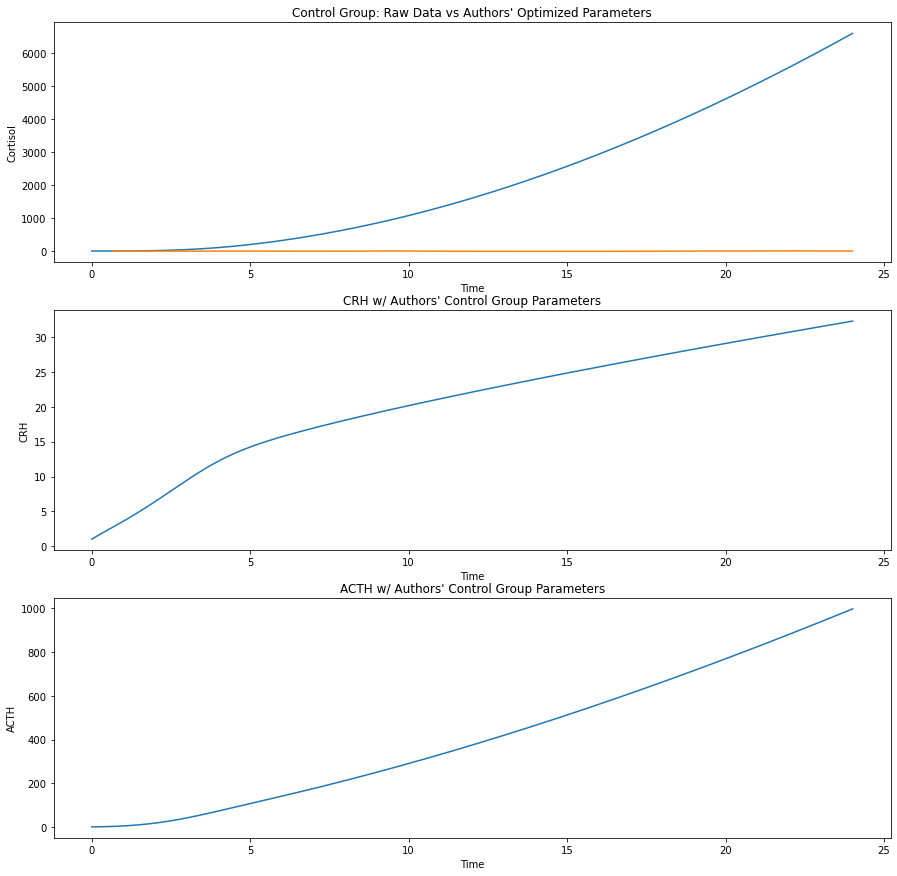

In [816]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))
ax1.plot(sim[:,0], sim[:,3], label = "Simulation")
ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Yehuda Control Group")
ax1.set(xlabel = "Time", ylabel = "Cortisol", title = "Control Group: Raw Data vs Authors' Optimized Parameters")
ax2.plot(sim[:,0], sim[:,1])
ax2.set(xlabel = "Time", ylabel = "CRH", title = "CRH w/ Authors' Control Group Parameters")
ax3.plot(sim[:,0], sim[:,2])
ax3.set(xlabel = "Time", ylabel = "ACTH", title = "ACTH w/ Authors' Control Group Parameters")

plt.savefig("testing-params-kb-0.01.pdf", dpi = 300)

## Load Simulated Concentration Data from Files and Plot <a name="load-and-plot"></a>

In [ ]:
sims_gr = np.genfromtxt("sriram-sims-gr-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
sims_cort = np.genfromtxt("sriram-sims-cort-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
sims_crh = np.genfromtxt("sriram-sims-crh-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
cims_acth = np.genfromtxt("sriram-sims-acth-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")

In [122]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,59], label = "Nelson ACTH Data - Patient 58", color = "orange")
ax1.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Simulated ACTH Data", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "Nelson ACTH")

ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,59], label = "Nelson Cortisol Data - Patient 58", color = "orange")
ax2.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulated Cortisol Data", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Nelson Cortisol")


plt.savefig("sriramModel-nelson-patient24-5-iterations-all-params.png", dpi = 300)

## Dependencies <a name="dependencies"></a>

In [4]:
%load_ext watermark

In [5]:
%watermark --iversions

distutils : 3.7.7
scipy     : 1.1.0
matplotlib: 3.0.1
platform  : 1.0.8
sys       : 3.7.7 (default, May  6 2020, 04:59:01) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas    : 0.23.4
PyDSTool  : 0.91.0
numpy     : 1.21.5
mpld3     : 0.3.1.dev1

